### Data Collection And Preparation

### Importing the libraries

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost
import pickle as pkl
from sklearn.model_selection import cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings ("ignore")

In [4]:
class MultiColumnLabelEncoder:

    def __init__(self, columns=None):
        self.columns = columns # array of column names to encode


    def fit(self, X, y=None):
        self.encoders = {}
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            self.encoders[col] = LabelEncoder().fit(X[col])
        return self


    def transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].transform(X[col])
        return output


    def fit_transform(self, X, y=None):
        return self.fit(X,y).transform(X)


    def inverse_transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].inverse_transform(X[col])
        return output

## Read the Datasets

In [5]:
train = pd.read_csv('panic_disorder_dataset_training.csv')
train.head()

Participant ID  Age  Gender Family History Personal History  \
0               1   38    Male             No              Yes   
1               2   51    Male             No               No   
2               3   32  Female            Yes               No   
3               4   64  Female             No               No   
4               5   31    Male            Yes               No   

  Current Stressors             Symptoms  Severity Impact on Life  \
0          Moderate  Shortness of breath      Mild           Mild   
1              High        Panic attacks      Mild           Mild   
2              High        Panic attacks      Mild    Significant   
3          Moderate           Chest pain  Moderate       Moderate   
4          Moderate        Panic attacks      Mild       Moderate   

  Demographics Medical History  Psychiatric History Substance Use  \
0        Rural        Diabetes     Bipolar disorder           NaN   
1        Urban          Asthma     Anxiety disorder         Drugs   
2        Urban        Diabetes  Depressive disorder           NaN   
3        Rural        Diabetes                  NaN           NaN   
4        Rural          Asthma                  NaN         Drugs   

  Coping Mechanisms Social Support Lifestyle Factors  Panic Disorder Diagnosis  
0       Socializing           High     Sleep quality                         0  
1          Exercise           High     Sleep quality                         0  
2   Seeking therapy       Moderate          Exercise                         0  
3        Meditation           High          Exercise                         0  
4   Seeking therapy            Low     Sleep quality                         0

In [6]:
test = pd.read_csv('panic_disorder_dataset_testing.csv')
test.head()

Participant ID  Age  Gender Family History Personal History  \
0               1   41    Male            Yes               No   
1               2   20  Female            Yes               No   
2               3   32    Male            Yes              Yes   
3               4   41  Female            Yes              Yes   
4               5   36  Female            Yes               No   

  Current Stressors             Symptoms  Severity Impact on Life  \
0              High  Shortness of breath      Mild           Mild   
1               Low  Shortness of breath      Mild    Significant   
2              High        Panic attacks    Severe           Mild   
3          Moderate  Shortness of breath  Moderate    Significant   
4              High           Chest pain    Severe    Significant   

  Demographics Medical History  Psychiatric History Substance Use  \
0        Urban        Diabetes     Bipolar disorder       Alcohol   
1        Urban          Asthma     Anxiety disorder         Drugs   
2        Rural   Heart disease     Bipolar disorder         Drugs   
3        Urban   Heart disease     Anxiety disorder           NaN   
4        Rural          Asthma  Depressive disorder           NaN   

  Coping Mechanisms Social Support Lifestyle Factors  Panic Disorder Diagnosis  
0   Seeking therapy            Low          Exercise                         0  
1          Exercise           High              Diet                         0  
2        Meditation       Moderate          Exercise                         0  
3          Exercise           High     Sleep quality                         0  
4   Seeking therapy            Low          Exercise                         0

In [7]:
print('Train data shape:', train.shape)
print('Test data shape:', test.shape)

Train data shape: (100000, 17)
Test data shape: (20000, 17)


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Participant ID            100000 non-null  int64 
 1   Age                       100000 non-null  int64 
 2   Gender                    100000 non-null  object
 3   Family History            100000 non-null  object
 4   Personal History          100000 non-null  object
 5   Current Stressors         100000 non-null  object
 6   Symptoms                  100000 non-null  object
 7   Severity                  100000 non-null  object
 8   Impact on Life            100000 non-null  object
 9   Demographics              100000 non-null  object
 10  Medical History           74827 non-null   object
 11  Psychiatric History       75079 non-null   object
 12  Substance Use             66626 non-null   object
 13  Coping Mechanisms         100000 non-null  object
 14  Socia

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Participant ID            20000 non-null  int64 
 1   Age                       20000 non-null  int64 
 2   Gender                    20000 non-null  object
 3   Family History            20000 non-null  object
 4   Personal History          20000 non-null  object
 5   Current Stressors         20000 non-null  object
 6   Symptoms                  20000 non-null  object
 7   Severity                  20000 non-null  object
 8   Impact on Life            20000 non-null  object
 9   Demographics              20000 non-null  object
 10  Medical History           14999 non-null  object
 11  Psychiatric History       15011 non-null  object
 12  Substance Use             13383 non-null  object
 13  Coping Mechanisms         20000 non-null  object
 14  Social Support        

## Handling Missing Value

In [10]:
train.isnull().sum()

Participant ID                  0
Age                             0
Gender                          0
Family History                  0
Personal History                0
Current Stressors               0
Symptoms                        0
Severity                        0
Impact on Life                  0
Demographics                    0
Medical History             25173
Psychiatric History         24921
Substance Use               33374
Coping Mechanisms               0
Social Support                  0
Lifestyle Factors               0
Panic Disorder Diagnosis        0
dtype: int64

In [11]:
test.isnull().sum()

Participant ID                 0
Age                            0
Gender                         0
Family History                 0
Personal History               0
Current Stressors              0
Symptoms                       0
Severity                       0
Impact on Life                 0
Demographics                   0
Medical History             5001
Psychiatric History         4989
Substance Use               6617
Coping Mechanisms              0
Social Support                 0
Lifestyle Factors              0
Panic Disorder Diagnosis       0
dtype: int64

In [12]:
train.isnull().any()

Participant ID              False
Age                         False
Gender                      False
Family History              False
Personal History            False
Current Stressors           False
Symptoms                    False
Severity                    False
Impact on Life              False
Demographics                False
Medical History              True
Psychiatric History          True
Substance Use                True
Coping Mechanisms           False
Social Support              False
Lifestyle Factors           False
Panic Disorder Diagnosis    False
dtype: bool

In [13]:
test.isnull().any()

Participant ID              False
Age                         False
Gender                      False
Family History              False
Personal History            False
Current Stressors           False
Symptoms                    False
Severity                    False
Impact on Life              False
Demographics                False
Medical History              True
Psychiatric History          True
Substance Use                True
Coping Mechanisms           False
Social Support              False
Lifestyle Factors           False
Panic Disorder Diagnosis    False
dtype: bool

In [14]:
train["Medical History"].unique()

array(['Diabetes', 'Asthma', nan, 'Heart disease'], dtype=object)

In [15]:
train["Psychiatric History"].unique()

array(['Bipolar disorder', 'Anxiety disorder', 'Depressive disorder', nan],
      dtype=object)

In [16]:
train["Substance Use"].unique()

array([nan, 'Drugs', 'Alcohol'], dtype=object)

In [17]:
test["Medical History"].unique()

array(['Diabetes', 'Asthma', 'Heart disease', nan], dtype=object)

In [18]:
test["Psychiatric History"].unique()

array(['Bipolar disorder', 'Anxiety disorder', 'Depressive disorder', nan],
      dtype=object)

In [19]:
test["Substance Use"].unique()

array(['Alcohol', 'Drugs', nan], dtype=object)

### Fill null values

In [20]:
train["Medical History"].fillna("none", inplace=True)
train["Medical History"].unique()

array(['Diabetes', 'Asthma', 'none', 'Heart disease'], dtype=object)

In [21]:
train["Psychiatric History"].fillna("none", inplace=True)
train["Psychiatric History"].unique()

array(['Bipolar disorder', 'Anxiety disorder', 'Depressive disorder',
       'none'], dtype=object)

In [22]:
train["Substance Use"].fillna("none", inplace=True)
train["Substance Use"].unique()

array(['none', 'Drugs', 'Alcohol'], dtype=object)

In [23]:
test["Medical History"].fillna("none", inplace=True)
test["Medical History"].unique()

array(['Diabetes', 'Asthma', 'Heart disease', 'none'], dtype=object)

In [24]:
test["Psychiatric History"].fillna("none", inplace=True)
test["Psychiatric History"].unique()

array(['Bipolar disorder', 'Anxiety disorder', 'Depressive disorder',
       'none'], dtype=object)

In [25]:
test["Substance Use"].fillna("none", inplace=True)
test["Substance Use"].unique()

array(['Alcohol', 'Drugs', 'none'], dtype=object)

### Checking null values again

In [26]:
train.isnull().any()

Participant ID              False
Age                         False
Gender                      False
Family History              False
Personal History            False
Current Stressors           False
Symptoms                    False
Severity                    False
Impact on Life              False
Demographics                False
Medical History             False
Psychiatric History         False
Substance Use               False
Coping Mechanisms           False
Social Support              False
Lifestyle Factors           False
Panic Disorder Diagnosis    False
dtype: bool

In [27]:
test.isnull().any()

Participant ID              False
Age                         False
Gender                      False
Family History              False
Personal History            False
Current Stressors           False
Symptoms                    False
Severity                    False
Impact on Life              False
Demographics                False
Medical History             False
Psychiatric History         False
Substance Use               False
Coping Mechanisms           False
Social Support              False
Lifestyle Factors           False
Panic Disorder Diagnosis    False
dtype: bool

## Handling Categorical Values

In [28]:
#categorical values
cat_cols=[]
for i in train.columns:
    if train[i].dtype=='object':
        cat_cols.append(i)
cat_cols

['Gender',
 'Family History',
 'Personal History',
 'Current Stressors',
 'Symptoms',
 'Severity',
 'Impact on Life',
 'Demographics',
 'Medical History',
 'Psychiatric History',
 'Substance Use',
 'Coping Mechanisms',
 'Social Support',
 'Lifestyle Factors']

In [29]:
#Label Encoding
multi = MultiColumnLabelEncoder(columns= cat_cols)

train = multi.fit_transform(train)

test =  multi.fit_transform(test)

## SMOTE on Panic Disorder Diagnosis - Over Sampling The Data

In [30]:
print(train["Panic Disorder Diagnosis"].value_counts())
print(test["Panic Disorder Diagnosis"].value_counts())

Panic Disorder Diagnosis
0    95715
1     4285
Name: count, dtype: int64
Panic Disorder Diagnosis
0    19159
1      841
Name: count, dtype: int64


In [31]:
smote=SMOTE()

In [32]:
y_train = train["Panic Disorder Diagnosis"]
x_train = train.drop(columns=['Participant ID','Panic Disorder Diagnosis'],axis=1)

In [33]:
y_test = test["Panic Disorder Diagnosis"]
x_test = test.drop(columns=['Participant ID','Panic Disorder Diagnosis'],axis=1)

In [34]:
x_res_train,y_res_train = smote.fit_resample(x_train,y_train)

In [35]:
print(y_train.value_counts())
print(y_res_train.value_counts())

Panic Disorder Diagnosis
0    95715
1     4285
Name: count, dtype: int64
Panic Disorder Diagnosis
0    95715
1    95715
Name: count, dtype: int64


In [36]:
x_res_train

Age  Gender  Family History  Personal History  Current Stressors  \
0        38       1               0                 1                  2   
1        51       1               0                 0                  0   
2        32       0               1                 0                  0   
3        64       0               0                 0                  2   
4        31       1               1                 0                  2   
...     ...     ...             ...               ...                ...   
191425   61       0               0                 1                  0   
191426   61       1               1                 1                  0   
191427   19       1               1                 1                  0   
191428   37       1               1                 0                  0   
191429   59       0               0                 1                  0   

        Symptoms  Severity  Impact on Life  Demographics  Medical History  \
0              4         0               0             0                1   
1              3         0               0             1                0   
2              3         0               2             1                1   
3              0         1               1             0                1   
4              3         0               1             0                0   
...          ...       ...             ...           ...              ...   
191425         0         0               2             0                3   
191426         3         2               1             1                0   
191427         1         0               2             0                1   
191428         2         1               2             0                0   
191429         0         0               2             0                0   

        Psychiatric History  Substance Use  Coping Mechanisms  Social Support  \
0                         1              2                  3               0   
1                         0              1                  0               0   
2                         2              2                  2               2   
3                         3              2                  1               0   
4                         3              1                  2               1   
...                     ...            ...                ...             ...   
191425                    2              1                  3               0   
191426                    2              0                  0               1   
191427                    2              1                  2               1   
191428                    2              0                  1               0   
191429                    3              0                  1               1   

        Lifestyle Factors  
0                       2  
1                       2  
2                       1  
3                       1  
4                       2  
...                   ...  
191425                  2  
191426                  2  
191427                  2  
191428                  2  
191429                  2  

[191430 rows x 15 columns]

In [37]:
y_res_train

0         0
1         0
2         0
3         0
4         0
         ..
191425    1
191426    1
191427    1
191428    1
191429    1
Name: Panic Disorder Diagnosis, Length: 191430, dtype: int64

## Feature Selection

In [38]:
#Calculating Fscore and p value
f_p_values=chi2(x_res_train,y_res_train)
f_p_values
# Here first array has F values and second array has P values.

(array([   64.968662  ,  2801.9521863 ,    84.06577595,   360.77928325,
        37521.87037401,   273.69854326,  3218.62904705,  4951.49352831,
         6461.13635568,  7402.81368434,  5300.91573927,  4822.06068071,
          310.81574497,  1747.18479819, 35569.11363017]),
 array([7.60987120e-16, 0.00000000e+00, 4.78584166e-20, 1.90501227e-80,
        0.00000000e+00, 1.77356771e-61, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.45051052e-69, 0.00000000e+00, 0.00000000e+00]))

In [39]:
#p Values
p_values=pd.Series(f_p_values[1])
p_values.index= x_train.columns
p_values.sort_index(ascending=True)
# We sort the P values array based on the Chi scores and select moderately important and least important feature/s.

Age                    7.609871e-16
Coping Mechanisms      1.450511e-69
Current Stressors      0.000000e+00
Demographics           0.000000e+00
Family History         4.785842e-20
Gender                 0.000000e+00
Impact on Life         0.000000e+00
Lifestyle Factors      0.000000e+00
Medical History        0.000000e+00
Personal History       1.905012e-80
Psychiatric History    0.000000e+00
Severity               0.000000e+00
Social Support         0.000000e+00
Substance Use          0.000000e+00
Symptoms               1.773568e-61
dtype: float64

# Exploratory Data Analysis

## Descriptive Statistical

In [40]:
# reverse transforming train dataframe
train_invt = multi.inverse_transform(train)

train_invt.describe(include='all')

Participant ID            Age  Gender Family History Personal History  \
count    100000.000000  100000.000000  100000         100000           100000   
unique             NaN            NaN       2              2                2   
top                NaN            NaN    Male            Yes               No   
freq               NaN            NaN   50052          50042            50210   
mean      50000.500000      41.454300     NaN            NaN              NaN   
std       28867.657797      13.839204     NaN            NaN              NaN   
min           1.000000      18.000000     NaN            NaN              NaN   
25%       25000.750000      29.000000     NaN            NaN              NaN   
50%       50000.500000      41.000000     NaN            NaN              NaN   
75%       75000.250000      53.000000     NaN            NaN              NaN   
max      100000.000000      65.000000     NaN            NaN              NaN   

       Current Stressors                Symptoms Severity Impact on Life  \
count             100000                  100000   100000         100000   
unique                 3                       5        3              3   
top                  Low  Fear of losing control   Severe           Mild   
freq               33409                   20236    33510          33452   
mean                 NaN                     NaN      NaN            NaN   
std                  NaN                     NaN      NaN            NaN   
min                  NaN                     NaN      NaN            NaN   
25%                  NaN                     NaN      NaN            NaN   
50%                  NaN                     NaN      NaN            NaN   
75%                  NaN                     NaN      NaN            NaN   
max                  NaN                     NaN      NaN            NaN   

       Demographics Medical History Psychiatric History Substance Use  \
count        100000          100000              100000        100000   
unique            2               4                   4             3   
top           Rural            none    Bipolar disorder       Alcohol   
freq          50087           25173               25058         33445   
mean            NaN             NaN                 NaN           NaN   
std             NaN             NaN                 NaN           NaN   
min             NaN             NaN                 NaN           NaN   
25%             NaN             NaN                 NaN           NaN   
50%             NaN             NaN                 NaN           NaN   
75%             NaN             NaN                 NaN           NaN   
max             NaN             NaN                 NaN           NaN   

       Coping Mechanisms Social Support Lifestyle Factors  \
count             100000         100000            100000   
unique                 4              3                 3   
top          Socializing           High          Exercise   
freq               25197          33453             33597   
mean                 NaN            NaN               NaN   
std                  NaN            NaN               NaN   
min                  NaN            NaN               NaN   
25%                  NaN            NaN               NaN   
50%                  NaN            NaN               NaN   
75%                  NaN            NaN               NaN   
max                  NaN            NaN               NaN   

        Panic Disorder Diagnosis  
count               100000.00000  
unique                       NaN  
top                          NaN  
freq                         NaN  
mean                     0.04285  
std                      0.20252  
min                      0.00000  
25%                      0.00000  
50%                      0.00000  
75%                      0.00000  
max                      1.00000

## Age

In [41]:
plt.hist(train_invt['Age'])

(array([10521., 10303., 10488.,  8310., 10415., 10537.,  8275., 10564.,
        10255., 10332.]),
 array([18. , 22.7, 27.4, 32.1, 36.8, 41.5, 46.2, 50.9, 55.6, 60.3, 65. ]),
 <BarContainer object of 10 artists>)

In [42]:
sns.distplot(train_invt.Age)

<Axes: xlabel='Age', ylabel='Density'>

## Gender

[Text(0, 0, '50052'), Text(0, 0, '49948')]

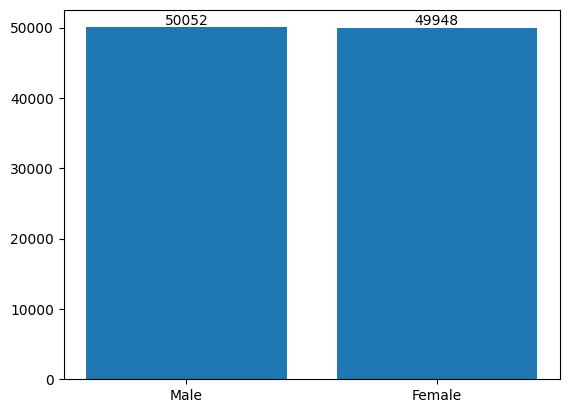

In [43]:
y_axis = train_invt['Gender'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Family History

In [44]:
y_axis = train_invt['Family History'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

[Text(0, 0, '50042'), Text(0, 0, '49958')]

## Personal History

[Text(0, 0, '50210'), Text(0, 0, '49790')]

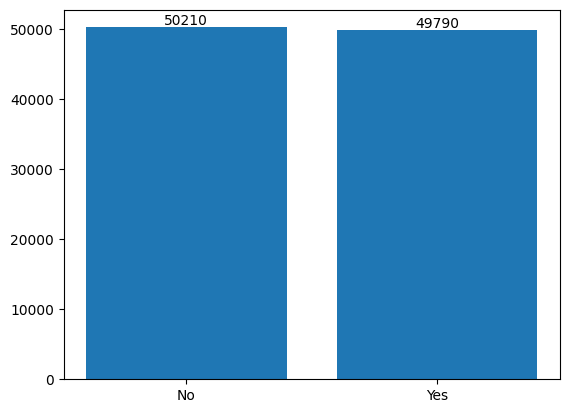

In [45]:
y_axis = train_invt['Personal History'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Current Stressors

[Text(0, 0, '33409'), Text(0, 0, '33369'), Text(0, 0, '33222')]

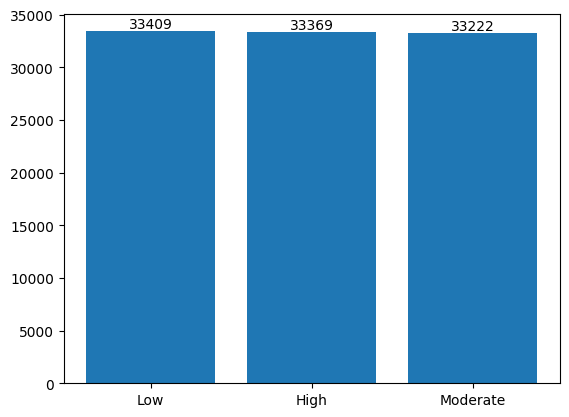

In [46]:
y_axis = train_invt['Current Stressors'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Symptoms

[Text(0, 0, '20236'),
 Text(0, 0, '20138'),
 Text(0, 0, '19949'),
 Text(0, 0, '19893'),
 Text(0, 0, '19784')]

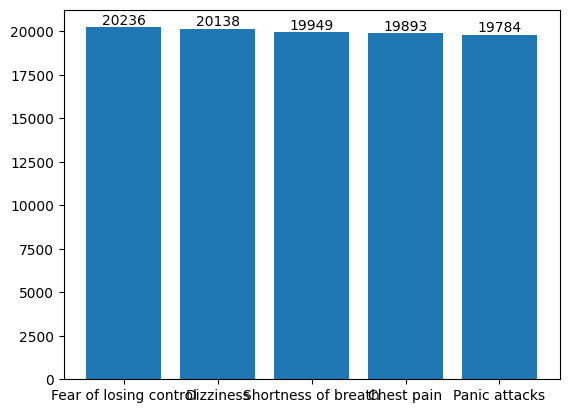

In [47]:
y_axis = train_invt['Symptoms'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Severity

[Text(0, 0, '33510'), Text(0, 0, '33365'), Text(0, 0, '33125')]

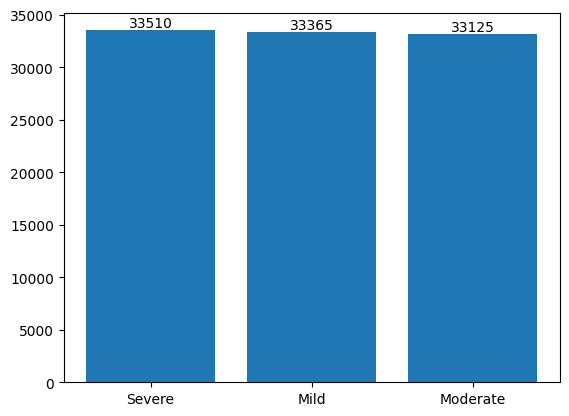

In [48]:
y_axis = train_invt['Severity'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Impact on Life

[Text(0, 0, '33452'), Text(0, 0, '33333'), Text(0, 0, '33215')]

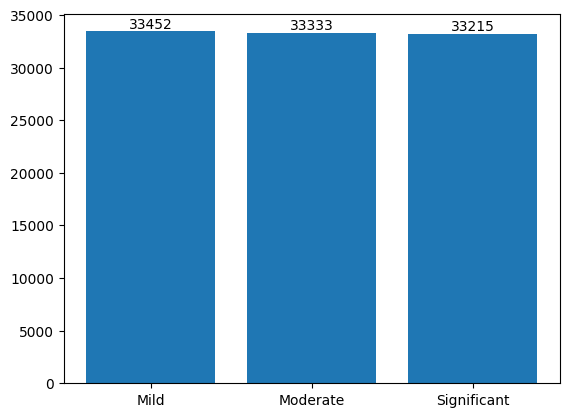

In [49]:
y_axis = train_invt['Impact on Life'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Demographics

[Text(0, 0, '50087'), Text(0, 0, '49913')]

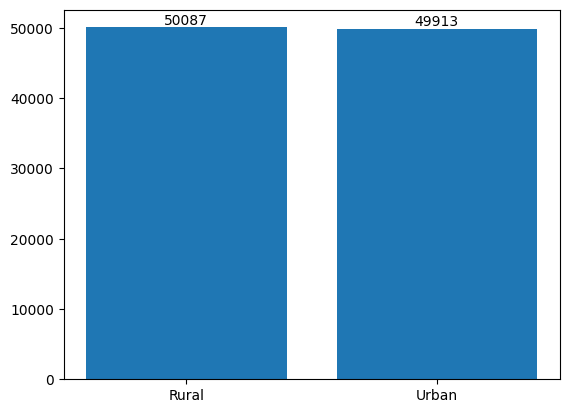

In [50]:
y_axis = train_invt['Demographics'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Medical History

[Text(0, 0, '25173'),
 Text(0, 0, '25074'),
 Text(0, 0, '24993'),
 Text(0, 0, '24760')]

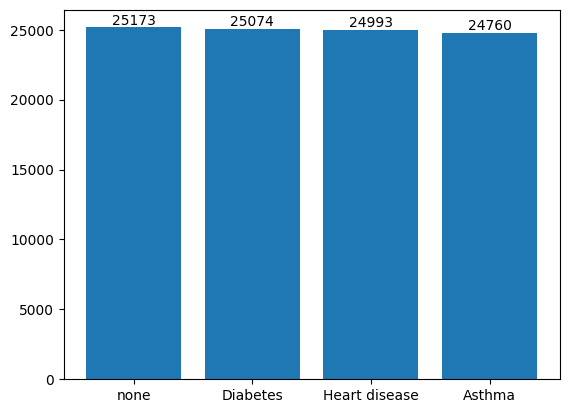

In [51]:
y_axis = train_invt['Medical History'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Psychiatric History

[Text(0, 0, '25058'),
 Text(0, 0, '25025'),
 Text(0, 0, '24996'),
 Text(0, 0, '24921')]

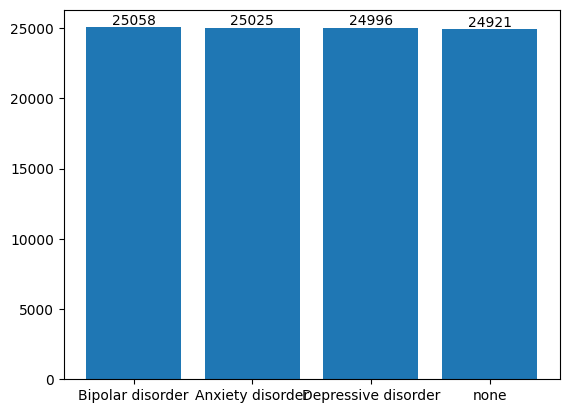

In [52]:
y_axis = train_invt['Psychiatric History'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Substance Use

[Text(0, 0, '33445'), Text(0, 0, '33374'), Text(0, 0, '33181')]

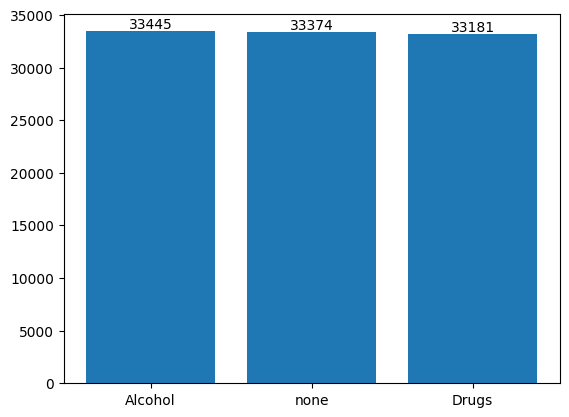

In [53]:
y_axis = train_invt['Substance Use'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Coping Mechanisms

[Text(0, 0, '25197'),
 Text(0, 0, '25037'),
 Text(0, 0, '24925'),
 Text(0, 0, '24841')]

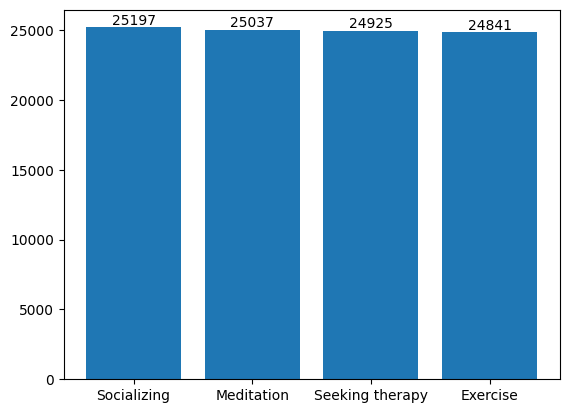

In [54]:
y_axis = train_invt['Coping Mechanisms'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Social Support

[Text(0, 0, '33453'), Text(0, 0, '33353'), Text(0, 0, '33194')]

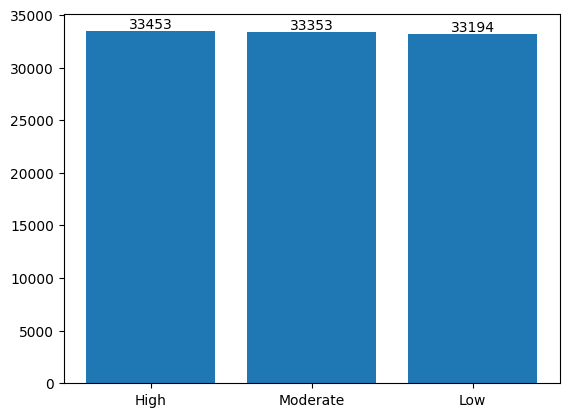

In [55]:
y_axis = train_invt['Social Support'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Lifestyle Factors

[Text(0, 0, '33597'), Text(0, 0, '33331'), Text(0, 0, '33072')]

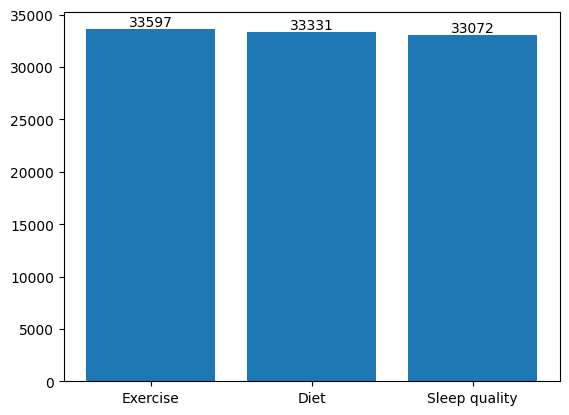

In [56]:
y_axis = train_invt['Lifestyle Factors'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

## Panic Disorder Diagnosis

[Text(0, 0, '95715'), Text(0, 0, '4285')]

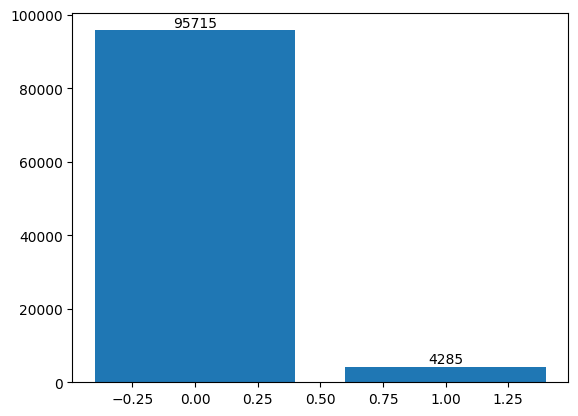

In [57]:
y_axis = train_invt['Panic Disorder Diagnosis'].value_counts()
x_axis = y_axis.index.values
bars = plt.bar(x_axis,y_axis)
plt.bar_label(bars)

<Axes: xlabel='Panic Disorder Diagnosis', ylabel='count'>

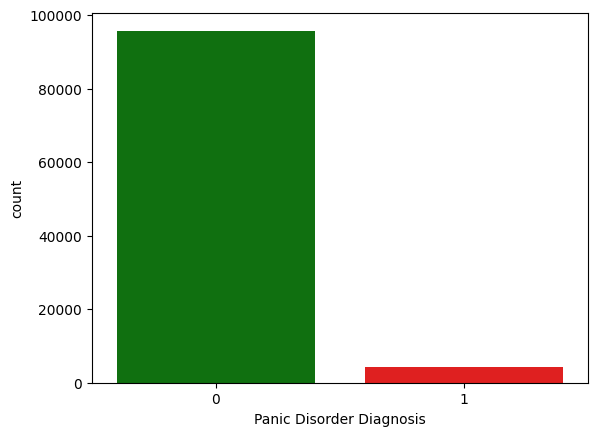

In [58]:
sns.countplot(data=train_invt,x='Panic Disorder Diagnosis',palette=['green','red'])


### Bivariate Variables 

Text(0.5, 1.0, 'Lifestyle Factors')

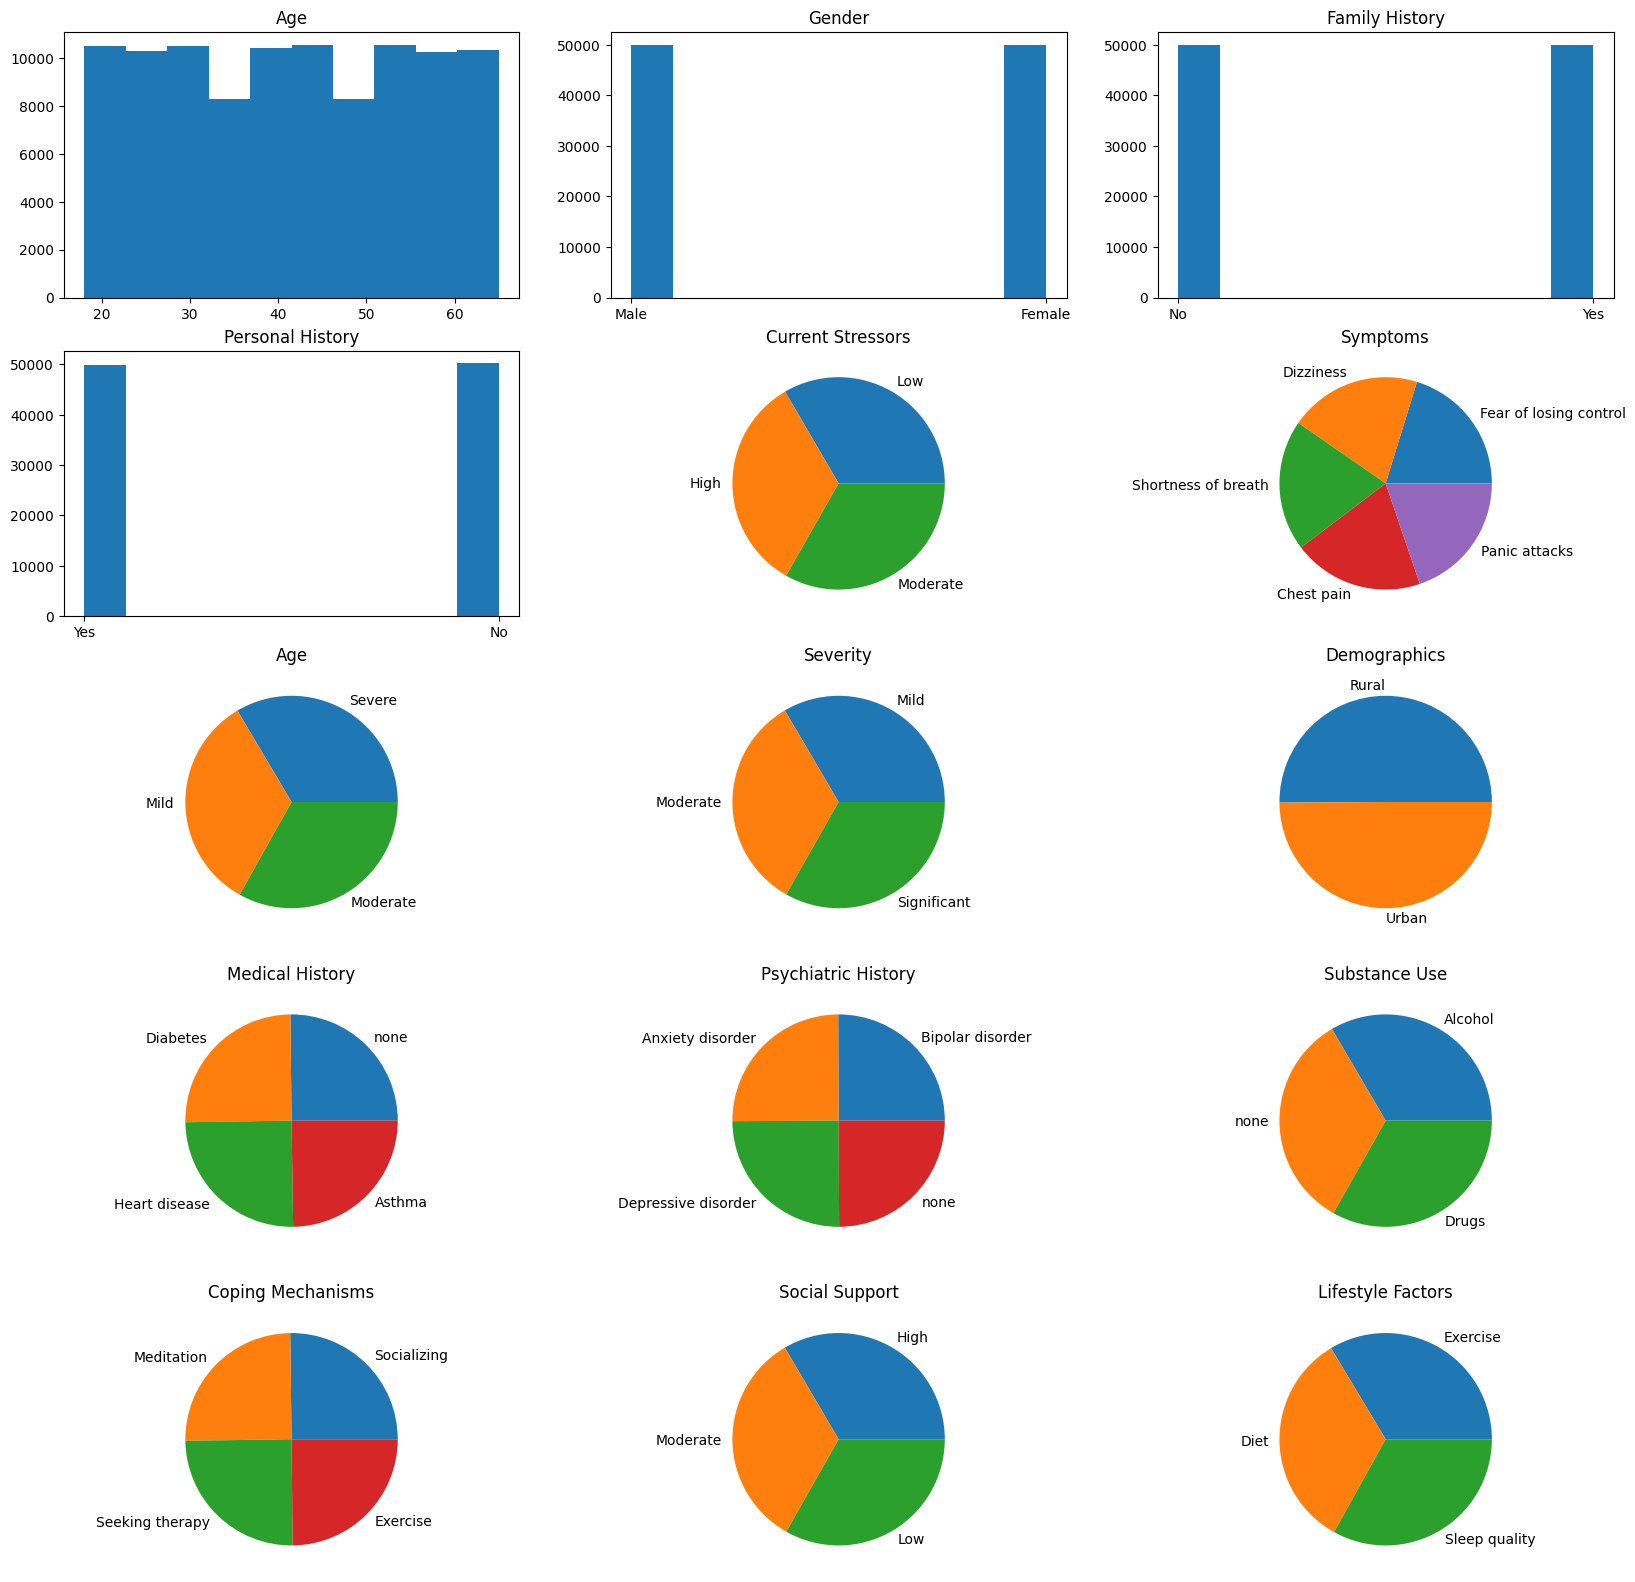

In [59]:
plt.figure(figsize=(20,20))

plt.subplot(5,3,1)
y_axis = train_invt['Age'].value_counts()
plt.hist(train['Age'])
plt.title('Age')

plt.subplot(5,3,2)
y_axis = train_invt['Gender']
plt.hist(y_axis)
plt.title('Gender')


plt.subplot(5,3,3)
y_axis = train_invt['Family History']
plt.hist(y_axis)
plt.title('Family History')


plt.subplot(5,3,4)
y_axis = train_invt['Personal History']
plt.hist(y_axis)
plt.title('Personal History')


plt.subplot(5,3,5)
y_axis = train_invt['Current Stressors'].value_counts()
plt.pie(y_axis, labels = y_axis.index)
plt.title('Current Stressors')


plt.subplot(5,3,6)
y_axis = train_invt['Symptoms'].value_counts()
plt.pie(y_axis, labels = y_axis.index)
plt.title('Symptoms')


plt.subplot(5,3,7)
y_axis = train_invt['Severity'].value_counts()
plt.pie(y_axis, labels = y_axis.index)
plt.title('Age')


plt.subplot(5,3,8)
y_axis = train_invt['Impact on Life'].value_counts()
plt.pie(y_axis, labels = y_axis.index)
plt.title('Severity')


plt.subplot(5,3,9)
y_axis = train_invt['Demographics'].value_counts()
plt.pie(y_axis, labels = y_axis.index)
plt.title('Demographics')


plt.subplot(5,3,10)
y_axis = train_invt['Medical History'].value_counts()
plt.pie(y_axis, labels = y_axis.index)
plt.title('Medical History')


plt.subplot(5,3,11)
y_axis = train_invt['Psychiatric History'].value_counts()
plt.pie(y_axis, labels = y_axis.index)
plt.title('Psychiatric History')


plt.subplot(5,3,12)
y_axis = train_invt['Substance Use'].value_counts()
plt.pie(y_axis, labels = y_axis.index)
plt.title('Substance Use')


plt.subplot(5,3,13)
y_axis = train_invt['Coping Mechanisms'].value_counts()
plt.pie(y_axis, labels=y_axis.index)
plt.title('Coping Mechanisms')


plt.subplot(5,3,14)
y_axis = train_invt['Social Support'].value_counts()
plt.pie(y_axis, labels=y_axis.index)
plt.title('Social Support')


plt.subplot(5,3,15)
y_axis = train_invt['Lifestyle Factors'].value_counts()
plt.pie(y_axis, labels = y_axis.index)
plt.title('Lifestyle Factors')



## Splitting the Data

In [60]:
print(x_res_train.shape,y_res_train.shape)
print(x_test.shape,y_test.shape)

(191430, 15) (191430,)
(20000, 15) (20000,)


In [61]:
x_res_train

Age  Gender  Family History  Personal History  Current Stressors  \
0        38       1               0                 1                  2   
1        51       1               0                 0                  0   
2        32       0               1                 0                  0   
3        64       0               0                 0                  2   
4        31       1               1                 0                  2   
...     ...     ...             ...               ...                ...   
191425   61       0               0                 1                  0   
191426   61       1               1                 1                  0   
191427   19       1               1                 1                  0   
191428   37       1               1                 0                  0   
191429   59       0               0                 1                  0   

        Symptoms  Severity  Impact on Life  Demographics  Medical History  \
0              4         0               0             0                1   
1              3         0               0             1                0   
2              3         0               2             1                1   
3              0         1               1             0                1   
4              3         0               1             0                0   
...          ...       ...             ...           ...              ...   
191425         0         0               2             0                3   
191426         3         2               1             1                0   
191427         1         0               2             0                1   
191428         2         1               2             0                0   
191429         0         0               2             0                0   

        Psychiatric History  Substance Use  Coping Mechanisms  Social Support  \
0                         1              2                  3               0   
1                         0              1                  0               0   
2                         2              2                  2               2   
3                         3              2                  1               0   
4                         3              1                  2               1   
...                     ...            ...                ...             ...   
191425                    2              1                  3               0   
191426                    2              0                  0               1   
191427                    2              1                  2               1   
191428                    2              0                  1               0   
191429                    3              0                  1               1   

        Lifestyle Factors  
0                       2  
1                       2  
2                       1  
3                       1  
4                       2  
...                   ...  
191425                  2  
191426                  2  
191427                  2  
191428                  2  
191429                  2  

[191430 rows x 15 columns]

In [62]:
y_res_train

0         0
1         0
2         0
3         0
4         0
         ..
191425    1
191426    1
191427    1
191428    1
191429    1
Name: Panic Disorder Diagnosis, Length: 191430, dtype: int64

## Writing Function to Train the Models 

In [63]:
#temp_x = x_res_train
#temp_y = y_res_train

def train_models_eval(x_res_train,y_res_train,fts):
    print("\n---›RANDOM FOREST" )
    rf = RandomForestClassifier(random_state=1234)
    rf.fit(x_res_train[fts], y_res_train)
    y_pred=rf.predict(x_test[fts])
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print("SCORE:",rf.score(x_test[fts],y_test))
    
    print("\n---›DECISION TREE")
    dtf = DecisionTreeClassifier(random_state=1234)
    dtf.fit(x_res_train[fts], y_res_train)
    y_pred=dtf.predict(x_test[fts])
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print("SCORE:",dtf.score(x_test[fts],y_test))
    
    print(" \n--->KNN")
    knn = KNeighborsClassifier()
    knn.fit(x_res_train[fts], y_res_train)
    y_pred=knn.predict(x_test[fts])
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print("SCORE:",knn.score(x_test[fts],y_test))
    
    print("\n---›EXTRAS TREES CLASSIFIER")
    etc = ExtraTreesClassifier(random_state=1234)
    etc.fit(x_res_train[fts],y_res_train)
    y_pred=etc.predict(x_test[fts])
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print("SCORE:",etc.score(x_test[fts],y_test))
    
    print("\n---›XGBOOST" )
    xgb = xgboost.XGBClassifier ()
    xgb.fit(x_res_train[fts], y_res_train)
    y_pred=xgb.predict(x_test[fts])
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print("SCORE:", xgb.score(x_test[fts],y_test))
    
    return rf,dtf,knn,etc,xgb

In [64]:
fts = ['Gender',
 'Family History',
 'Personal History',
 'Current Stressors',
 'Symptoms',
 'Severity',
 'Impact on Life',
 'Demographics',
 'Medical History',
 'Psychiatric History',
 'Substance Use',
 'Coping Mechanisms',
 'Social Support',
 'Lifestyle Factors']
rf,dtf,knn,etc,xgb = train_models_eval(x_res_train,y_res_train,fts)


---›RANDOM FOREST
[[18852   307]
 [   18   823]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19159
           1       0.73      0.98      0.84       841

    accuracy                           0.98     20000
   macro avg       0.86      0.98      0.91     20000
weighted avg       0.99      0.98      0.98     20000

SCORE: 0.98375

---›DECISION TREE
[[18899   260]
 [    5   836]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19159
           1       0.76      0.99      0.86       841

    accuracy                           0.99     20000
   macro avg       0.88      0.99      0.93     20000
weighted avg       0.99      0.99      0.99     20000

SCORE: 0.98675
 
--->KNN
[[17898  1261]
 [   70   771]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     19159
           1       0.38      0.92      0.54       841

    accurac

In [65]:
knn.predict([x_test[fts].iloc[7,:]])

array([0], dtype=int64)

In [66]:
y_test[7]

0

## Build Model

In [67]:
pkl.dump(dtf, open('dtf.pkl','wb'))

# Hyperparameter Tuning

### Decision Tree

In [68]:
dtf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 1234,
 'splitter': 'best'}

In [69]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5,10,15],
    'min_samples_split': [2,3,10],
    'min_samples_leaf': [1,2,3],
    'max_features': [None, 'sqrt', 'log2']
}

#creating a decision tree classifier
dt_classifier = DecisionTreeClassifier(random_state=1234)

#Create GridSearchCV object
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, verbose = 1, n_jobs=-1)

#Fit the data to perform grid search
grid_search.fit(x_res_train[fts], y_res_train)

#Print the best hyperparameteers
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score", grid_search.best_score_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score 0.9917411064096537


In [70]:
y_pred = grid_search.best_estimator_.predict(x_test[fts])
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("SCORE:",grid_search.best_estimator_.score(x_test[fts],y_test))

[[18895   264]
 [    4   837]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19159
           1       0.76      1.00      0.86       841

    accuracy                           0.99     20000
   macro avg       0.88      0.99      0.93     20000
weighted avg       0.99      0.99      0.99     20000

SCORE: 0.9866


### Random Forest

In [71]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1234,
 'verbose': 0,
 'warm_start': False}

In [72]:
param_grid = {
    'n_estimators': [50,100,200],
    'max_depth': [None, 5,10],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'max_features': ['sqrt', 'log2']
}

#creating a Ramdom Forest Classifier
rf_classifier = RandomForestClassifier(random_state=1234)

#Create GridSearchCV object
grid_search = GridSearchCV(rf_classifier, param_grid=param_grid, cv=5, verbose = 1, n_jobs=4)

#Fit the data to perform grid search
grid_search.fit(x_res_train[fts], y_res_train)

#Print the best hyperparameteers
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score", grid_search.best_score_)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


KeyboardInterrupt: 

In [ ]:
y_pred = grid_search.best_estimator_.predict(x_test[fts])
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("SCORE:",grid_search.best_estimator_.score(x_test[fts],y_test))

[[18861   298]
 [   12   829]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19159
           1       0.74      0.99      0.84       841

    accuracy                           0.98     20000
   macro avg       0.87      0.99      0.92     20000
weighted avg       0.99      0.98      0.99     20000

SCORE: 0.9845


### XGBoost

In [ ]:
xgb.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
param_grid = {
    'min_child_weight': [10,20],
    'gamma': [0,1.5,2.0],
    'colsample_bytree': [0.6,0.8,0.9],
    'max_depth': [4,5,6],
}

xgb = xgboost.XGBClassifier(learning_rate=0.5, n_estimators=100, objective='binary:logistic', nthread=3)

fitmodel = GridSearchCV(xgb, param_grid=param_grid, cv=5, refit=True, scoring = 'accuracy', n_jobs=4, verbose=3)

#Fit the data to perform grid search
fitmodel.fit(x_res_train[fts], y_res_train)

#Print the best hyperparameteers
print("Best Hyperparameters:", fitmodel.best_params_)
print("Best Score", fitmodel.best_score_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0, 'max_depth': 6, 'min_child_weight': 10}
Best Score 0.988549339184036


In [ ]:
y_pred = fitmodel.best_estimator_.predict(x_test[fts])
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("SCORE:",fitmodel.best_estimator_.score(x_test[fts],y_test))

[[18774   385]
 [    1   840]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19159
           1       0.69      1.00      0.81       841

    accuracy                           0.98     20000
   macro avg       0.84      0.99      0.90     20000
weighted avg       0.99      0.98      0.98     20000

SCORE: 0.9807


In [ ]:
y_pred = grid_search.best_estimator_.predict(x_test[fts])
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("SCORE:",grid_search.best_estimator_.score(x_test[fts],y_test))

[[18861   298]
 [   12   829]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19159
           1       0.74      0.99      0.84       841

    accuracy                           0.98     20000
   macro avg       0.87      0.99      0.92     20000
weighted avg       0.99      0.98      0.99     20000

SCORE: 0.9845
